In [45]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Loading Data

In [46]:
#import all csvs I'll use from the data folder into dataframes.
#each dataframe is accessed via datasets[<name>], with names 
#being the same as those in the list documents
path = './data/'
documents = ['diversity_school', 'salary_potential', 'tuition_income',
'historical_tuition', 'tuition_cost', 'table', 'cpi']
datasets = {}

for doc in documents:
    filename = path + doc + '.csv'
    df = pd.read_csv(filename, sep=',', header=0)
    datasets[doc] = df

In [47]:
#example of how to access a dataframe
datasets['cpi'].head(3)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
0,1985,105.5,106.0,106.4,106.9,107.3,107.6,107.8,108.0,108.3,108.7,109.0,109.3,107.6,106.6,108.5
1,1986,109.6,109.3,108.8,108.6,108.9,109.5,109.5,109.7,110.2,110.3,110.4,110.5,109.6,109.1,110.1
2,1987,111.2,111.6,112.1,112.7,113.1,113.5,113.8,114.4,115.0,115.3,115.4,115.4,113.6,112.4,114.9


## Data Cleaning

In [48]:
#the first year '1985-19862 is odd due to a footnote character from the webpage
datasets['table']['year'].unique()

array(['1985–862', '1995–96', '2000–01', '2001–02', '2002–03', '2003–04',
       '2004–05', '2005–06', '2006–07', '2007–08', '2008–09', '2009–10',
       '2010–11', '2011–12', '2012–13', '2013–14', '2014–15', '2015–16',
       '2016–17', '2017–18', '2018–19'], dtype=object)

In [49]:
#the odd value is cleaned, and the character '–' is replaced with '-' so that
#the year columns between historical_tuition and table match
datasets['table'].loc[datasets['table']['year'] == '1985–862', 'year'] = '1985-86'
datasets['table']['year'] = datasets['table']['year'].str.replace('–','-')
datasets['table'].head(1)

,type,year,Constant_All,Constant_4-Year,Constant_2-Year,Contemporary_All,Contemporary_4-Year,Contemporary_2-Year
0,All Institutions,1985-86,11369,12811,7836,4885,5504,3367


In [50]:
#table is in a format where I'm having trouble directly grabbing the tuition values
#I want, so instead I extract columns into seperate dataframes, and recombine them
#so that the format better matches historical_tuition.

const_all = datasets['table'][['type', 'year', 'Constant_All']]
const_all = const_all.rename(columns = {'Constant_All': 'tuition_2'})
const_all['tuition_type'] = 'All Constant'

const_4 = datasets['table'][['type', 'year', 'Constant_4-Year']]
const_4 = const_4.rename(columns = {'Constant_4-Year': 'tuition_2'})
const_4['tuition_type'] = '4 Year Constant'

const_2 = datasets['table'][['type', 'year', 'Constant_2-Year']]
const_2 = const_2.rename(columns = {'Constant_2-Year': 'tuition_2'})
const_2['tuition_type'] = '2 Year Constant'

curr_all = datasets['table'][['type', 'year', 'Contemporary_All']]
curr_all = curr_all.rename(columns = {'Contemporary_All': 'tuition_2'})
curr_all['tuition_type'] = 'All Current'

curr_4 = datasets['table'][['type', 'year', 'Contemporary_4-Year']]
curr_4 = curr_4.rename(columns = {'Contemporary_4-Year': 'tuition_2'})
curr_4['tuition_type'] = '4 Year Current'

curr_2 = datasets['table'][['type', 'year', 'Contemporary_2-Year']]
curr_2 = curr_2.rename(columns = {'Contemporary_2-Year': 'tuition_2'})
curr_2['tuition_type'] = '2 Year Current'

#The condiv_df could be done in one step, but I want to check the shape
#to make sure nothing's dissappearing
const = pd.concat([const_all, const_2,const_4], ignore_index=True)
curr = pd.concat([curr_all, curr_2, curr_4], ignore_index=True)
print(const.shape)
print(curr.shape)

all_table_rows = pd.concat([const, curr], ignore_index=True)
print(all_table_rows.shape)

(186, 4)
(186, 4)
(372, 4)


In [51]:
curr_2

,type,year,tuition_2,tuition_type
0,All Institutions,1985-86,3367,2 Year Current
1,All Institutions,1995-96,4725,2 Year Current
2,All Institutions,2000-01,5466,2 Year Current
3,All Institutions,2001-02,5718,2 Year Current
4,All Institutions,2002-03,6252,2 Year Current
...,...,...,...,...
57,Private,2014-15,24327,2 Year Current
58,Private,2015-16,24375,2 Year Current
59,Private,2016-17,24888,2 Year Current
60,Private,2017-18,25596,2 Year Current


In [52]:
#merge dataframes and look for NAs
hist_tuition = pd.merge(datasets['historical_tuition'], all_table_rows, how='left', on=['type','year','tuition_type'])
hist_tuition.isnull().sum().sum()

0

In [53]:
hist_tuition.head()

,type,year,tuition_type,tuition_cost,tuition_2
0,All Institutions,1985-86,All Constant,10893,11369
1,All Institutions,1985-86,4 Year Constant,12274,12811
2,All Institutions,1985-86,2 Year Constant,7508,7836
3,All Institutions,1985-86,All Current,4885,4885
4,All Institutions,1985-86,4 Year Current,5504,5504


In [54]:
#I make a third column with the average of the two tuition values
hist_tuition['avg_tuition'] = ((hist_tuition['tuition_cost'] + hist_tuition['tuition_2'])/2).astype(int)
hist_tuition.head(3)

,type,year,tuition_type,tuition_cost,tuition_2,avg_tuition
0,All Institutions,1985-86,All Constant,10893,11369,11131
1,All Institutions,1985-86,4 Year Constant,12274,12811,12542
2,All Institutions,1985-86,2 Year Constant,7508,7836,7672


## Question 1 - How has Univeristy Diversity Varies by State

In [55]:
div_df = datasets['diversity_school'][['total_enrollment','state','category','enrollment']]

In [56]:
div_df = div_df.groupby(['state','category'])[['enrollment', 'total_enrollment']].agg('sum')
div_df['percentage'] = div_df['enrollment']/div_df['total_enrollment']

In [57]:
div_df = div_df.reset_index()

In [58]:
cats = div_df['category'].unique()

In [59]:
div_race = div_df[(div_df['category'] != 'Women') & (div_df['category'] != 'Total Minority')][['state', 'category', 'percentage']]
race_stats = {}
for cat in div_race['category'].unique():
    race_stats[cat] = div_df[div_df['category'] == cat].describe()
   # print(cat)
    #print(div_df[div_df['category'] == cat].describe())
    #print('\n')
race_stats.keys()

dict_keys(['American Indian / Alaska Native', 'Asian', 'Black', 'Hispanic', 'Native Hawaiian / Pacific Islander', 'Non-Resident Foreign', 'Two Or More Races', 'Unknown', 'White'])

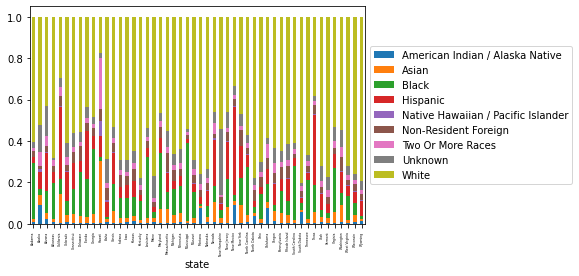

In [60]:
div_race = div_race.set_index(['state','category']).percentage
div_race.unstack().plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(axis='x', which='major', labelsize=3)
plt.savefig('./images/racial_diversity_2014')

In [61]:
div_gender = div_df[(div_df['category'] == 'Women')][['state', 'category', 'percentage']]
gender_stats = div_gender.describe()

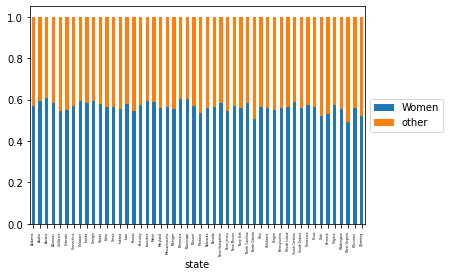

In [62]:

div_gender_temp = div_gender.copy()
div_gender_temp['percentage'] = 1 - div_gender_temp['percentage']
div_gender_temp['category'] = 'other'
div_gender = pd.concat([div_gender, div_gender_temp])
div_gender = div_gender.set_index(['state','category']).percentage
div_gender.unstack().plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(axis='x', which='major', labelsize=3)
plt.savefig('./images/gender_diversity_2014')

## Question 2 - How has Rate of Tuition Changed with Rate of Inflation?

In [63]:
#% change in cpi vs % change in tuition cost
cpi_df = datasets['cpi'][['Year', 'Annual']].copy()
cpi_df = cpi_df.rename(columns={'Year':'year', 'Annual':'cpi'})
cpi_df['1_year_change'] = (cpi_df['cpi'].pct_change())*100

In [64]:
starting_cpi = cpi_df.iloc[0]['cpi']
cpi_df['total_change'] = ((cpi_df['cpi'] - starting_cpi)/starting_cpi)*100
#cpi_df

In [65]:
#year column is reformatted to make join with hist_tuition possible.
#Only years that are present in hist_tuition are updated, and most 
#unneeded are dropped.
#1_year_change and total change for year '1985-86' are set equal to those 
# of year '1987', since the inflation rates were the same, according to out
#inflation calculator
cpi_df.at[0, "1_year_change"] = cpi_df.at[2, '1_year_change']
cpi_df.at[0, "total_change"] = cpi_df.at[2, 'total_change']
cpi_df = cpi_df.drop([1,2,3,4,5,6,7,8,9,11,12,13,14,35, 36])
year_map = {1985:'1985-86', 1995:'1995-96', 2000:'2000-01', 2001:'2001-02', 2002:'2002-03', 2003:'2003-04', 
    2004:'2004-05' ,2005:'2005-06',2006:'2006-07', 2007:'2007-08', 2008:'2008-09', 2009:'2009-10', 2010:'2010-11', 
    2011:'2011-12', 2012:'2012-13', 2013:'2013-14', 2014:'2014-15', 2015:'2015-16',2016:'2016-17',
    2017:'2017-18',2018:'2018-19', 2019:'2019-2020'}
cpi_df = cpi_df.replace({'year': year_map})

In [66]:
#Quality check
#cpi_df

In [67]:
#A very messy calculation of percentage change between tuition types and institution type

#CONSTANT
all__all_const_change = hist_tuition[(hist_tuition['tuition_type']=='All Constant') & (hist_tuition['type']=='All Institutions')]['avg_tuition'].pct_change()*100
all_4_const_change = hist_tuition[(hist_tuition['tuition_type']=='4 Year Constant') & (hist_tuition['type']=='All Institutions')]['avg_tuition'].pct_change()*100
all_2_const_change = hist_tuition[(hist_tuition['tuition_type']=='2 Year Constant') & (hist_tuition['type']=='All Institutions')]['avg_tuition'].pct_change()*100

pub_all_const_change = hist_tuition[(hist_tuition['tuition_type']=='All Constant') & (hist_tuition['type']=='Public')]['avg_tuition'].pct_change()*100
pub_4_const_change = hist_tuition[(hist_tuition['tuition_type']=='4 Year Constant') & (hist_tuition['type']=='Public')]['avg_tuition'].pct_change()*100
pub_2_const_change = hist_tuition[(hist_tuition['tuition_type']=='2 Year Constant') & (hist_tuition['type']=='Public')]['avg_tuition'].pct_change()*100

pri_all_const_change = hist_tuition[(hist_tuition['tuition_type']=='All Constant') & (hist_tuition['type']=='Private')]['avg_tuition'].pct_change()*100
pri_4_const_change = hist_tuition[(hist_tuition['tuition_type']=='4 Year Constant') & (hist_tuition['type']=='Private')]['avg_tuition'].pct_change()*100
pri_2_const_change = hist_tuition[(hist_tuition['tuition_type']=='2 Year Constant') & (hist_tuition['type']=='Private')]['avg_tuition'].pct_change()*100

constant = pd.concat([all__all_const_change, all_2_const_change, all_4_const_change, pub_all_const_change, pub_4_const_change, pub_2_const_change, pri_all_const_change, pri_4_const_change, pri_2_const_change])

#CURRENT
all__all_curr_change = hist_tuition[(hist_tuition['tuition_type']=='All Current') & (hist_tuition['type']=='All Institutions')]['avg_tuition'].pct_change()*100
all_4_curr_change = hist_tuition[(hist_tuition['tuition_type']=='4 Year Current') & (hist_tuition['type']=='All Institutions')]['avg_tuition'].pct_change()*100
all_2_curr_change = hist_tuition[(hist_tuition['tuition_type']=='2 Year Current') & (hist_tuition['type']=='All Institutions')]['avg_tuition'].pct_change()*100

pub_all_curr_change = hist_tuition[(hist_tuition['tuition_type']=='All Current') & (hist_tuition['type']=='Public')]['avg_tuition'].pct_change()*100
pub_4_curr_change = hist_tuition[(hist_tuition['tuition_type']=='4 Year Current') & (hist_tuition['type']=='Public')]['avg_tuition'].pct_change()*100
pub_2_curr_change = hist_tuition[(hist_tuition['tuition_type']=='2 Year Current') & (hist_tuition['type']=='Public')]['avg_tuition'].pct_change()*100

pri_all_curr_change = hist_tuition[(hist_tuition['tuition_type']=='All Current') & (hist_tuition['type']=='Private')]['avg_tuition'].pct_change()*100
pri_4_curr_change = hist_tuition[(hist_tuition['tuition_type']=='4 Year Current') & (hist_tuition['type']=='Private')]['avg_tuition'].pct_change()*100
pri_2_curr_change = hist_tuition[(hist_tuition['tuition_type']=='2 Year Current') & (hist_tuition['type']=='Private')]['avg_tuition'].pct_change()*100

current = pd.concat([all__all_curr_change, all_4_curr_change, all_2_curr_change, pub_all_curr_change, pub_4_curr_change, pub_2_curr_change, pri_all_curr_change, pri_2_curr_change, pri_4_curr_change])

#Merge
merged = pd.concat([constant, current]).sort_index()
merged

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
265    2.994580
266    0.248364
267    4.887738
268    4.886933
269    2.092308
Name: avg_tuition, Length: 270, dtype: float64

In [68]:
#Join change column onto tuition data frame, and rename columns
hist_tuition = hist_tuition.join(merged, rsuffix='_1', lsuffix='_2')
hist_tuition = hist_tuition.rename(columns={'avg_tuition_2': 'avg_tuition', 'avg_tuition_1':'1_year_change'})
hist_tuition


,type,year,tuition_type,tuition_cost,tuition_2,avg_tuition,1_year_change
0,All Institutions,1985-86,All Constant,10893,11369,11131,NaN
1,All Institutions,1985-86,4 Year Constant,12274,12811,12542,NaN
2,All Institutions,1985-86,2 Year Constant,7508,7836,7672,NaN
3,All Institutions,1985-86,All Current,4885,4885,4885,NaN
4,All Institutions,1985-86,4 Year Current,5504,5504,5504,NaN
...,...,...,...,...,...,...,...
265,Private,2016-17,4 Year Constant,41468,43279,42373,2.994580
266,Private,2016-17,2 Year Constant,24882,25976,25429,0.248364
267,Private,2016-17,All Current,40925,40922,40923,4.887738
268,Private,2016-17,4 Year Current,41468,41465,41466,4.886933


In [69]:
cpi_df.sample(3)

,year,cpi,1_year_change,total_change
17,2002-03,179.900,1.581028,67.193309
18,2003-04,184.000,2.279044,71.003717
24,2009-10,214.537,-0.355778,99.383829


In [70]:
hist_tuition.sample(3)

,type,year,tuition_type,tuition_cost,tuition_2,avg_tuition,1_year_change
4,All Institutions,1985-86,4 Year Current,5504,5504,5504,NaN
13,All Institutions,2000-01,4 Year Constant,17909,18692,18300,10.380602
165,Public,2012-13,All Current,15021,15021,15021,43.686627


In [71]:
#Lastly, add columns for the change in tuition since the first measured year
#magic values are used, but are just the appropriate value from avg_tuition from
#the year '1985-86

#All Institutions, All Constant
hist_tuition['total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & (hist_tuition['type'] == 'All Institutions') & 
    (hist_tuition['tuition_type'] == 'All Constant')]['avg_tuition'] - 11131
#All Institutions, 4 Year Constant
hist_tuition.loc[(hist_tuition['tuition_type'] == '4 Year Constant') & (hist_tuition['type'] == 'All Institutions'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & (hist_tuition['type'] == 'All Institutions') & (hist_tuition['tuition_type'] == '4 Year Constant')]['avg_tuition'] - 12542

#All Institutions, 2 Year Constant
hist_tuition.loc[(hist_tuition['tuition_type'] == '2 Year Constant') & (hist_tuition['type'] == 'All Institutions'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'All Institutions') & (hist_tuition['tuition_type'] == '2 Year Constant')]['avg_tuition'] - 7672

#All Institutions, All Current
hist_tuition.loc[(hist_tuition['tuition_type'] == 'All Current') & (hist_tuition['type'] == 'All Institutions'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'All Institutions') & (hist_tuition['tuition_type'] == 'All Current')]['avg_tuition'] - 4885
#All Institutions, 2 Year Current
hist_tuition.loc[(hist_tuition['tuition_type'] == '2 Year Current') & (hist_tuition['type'] == 'All Institutions'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'All Institutions') & (hist_tuition['tuition_type'] == '2 Year Current')]['avg_tuition'] - 3367
#All Institutions, 4 Year Current
hist_tuition.loc[(hist_tuition['tuition_type'] == '4 Year Current') & (hist_tuition['type'] == 'All Institutions'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'All Institutions') & (hist_tuition['tuition_type'] == '4 Year Current')]['avg_tuition'] - 5504

#Public Institutions, All Constant
hist_tuition.loc[(hist_tuition['tuition_type'] == 'All Constant') & (hist_tuition['type'] == 'Public'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'Public') & (hist_tuition['tuition_type'] == 'All Constant')]['avg_tuition'] - 8138
#Public Institutions, 2 Year Constant
hist_tuition.loc[(hist_tuition['tuition_type'] == '2 Year Constant') & (hist_tuition['type'] == 'Public'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'Public') & (hist_tuition['tuition_type'] == '2 Year Constant')]['avg_tuition'] - 6792
#Public Institutions, 4 Year Constant
hist_tuition.loc[(hist_tuition['tuition_type'] == '4 Year Constant') & (hist_tuition['type'] == 'Public'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'Public') & (hist_tuition['tuition_type'] == '4 Year Constant')]['avg_tuition'] - 8792

#Public Institutions, All Current
hist_tuition.loc[(hist_tuition['tuition_type'] == 'All Current') & (hist_tuition['type'] == 'Public'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'Public') & (hist_tuition['tuition_type'] == 'All Current')]['avg_tuition'] - 3571
#Public Institutions, 2 Year Current
hist_tuition.loc[(hist_tuition['tuition_type'] == '2 Year Current') & (hist_tuition['type'] == 'Public'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'Public') & (hist_tuition['tuition_type'] == '2 Year Current')]['avg_tuition'] - 2981
#Public Institutions, 4 Year Current
hist_tuition.loc[(hist_tuition['tuition_type'] == '4 Year Current') & (hist_tuition['type'] == 'Public'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'Public') & (hist_tuition['tuition_type'] == '4 Year Current')]['avg_tuition'] - 3859

#Private Institutions, All Constant
hist_tuition.loc[(hist_tuition['tuition_type'] == 'All Constant') & (hist_tuition['type'] == 'Private'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'Private') & (hist_tuition['tuition_type'] == 'All Constant')]['avg_tuition'] - 20245
#Private Institutions, 2 Year Constant
hist_tuition.loc[(hist_tuition['tuition_type'] == '2 Year Constant') & (hist_tuition['type'] == 'Private'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'Private') & (hist_tuition['tuition_type'] == '2 Year Constant')]['avg_tuition'] - 14838
#Private Institutions, 4 Year Constant
hist_tuition.loc[(hist_tuition['tuition_type'] == '4 Year Constant') & (hist_tuition['type'] == 'Private'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'Private') & (hist_tuition['tuition_type'] == '4 Year Constant')]['avg_tuition'] - 21028

#Private Institutions, All Current
hist_tuition.loc[(hist_tuition['tuition_type'] == 'All Current') & (hist_tuition['type'] == 'Private'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'Private') & (hist_tuition['tuition_type'] == 'All Current')]['avg_tuition'] - 8885
#Private Institutions, 2 Year Current
hist_tuition.loc[(hist_tuition['tuition_type'] == '2 Year Current') & (hist_tuition['type'] == 'Private'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'Private') & (hist_tuition['tuition_type'] == '2 Year Current')]['avg_tuition'] - 6512
#Private Institutions, 4 Year Current
hist_tuition.loc[(hist_tuition['tuition_type'] == '4 Year Current') & (hist_tuition['type'] == 'Private'), 'total_change'] = hist_tuition[(hist_tuition['year'] != '1985-86') & 
    (hist_tuition['type'] == 'Private') & (hist_tuition['tuition_type'] == '4 Year Current')]['avg_tuition'] - 9928


In [72]:
#make final dataframe
tuition_vs_inflation = hist_tuition.merge(cpi_df, on='year', suffixes=('_tuition', '_cpi'))
tuition_vs_inflation=tuition_vs_inflation.fillna(value={'total_change_tuition':0})
tuition_vs_inflation['dif_1_year'] = tuition_vs_inflation['1_year_change_tuition']- tuition_vs_inflation['1_year_change_cpi']
tuition_vs_inflation['dif_total'] = tuition_vs_inflation['total_change_tuition']- tuition_vs_inflation['total_change_cpi']


In [73]:
#Save dataframe to csv
tuition_vs_inflation.to_csv('./data/tuition_vs_inflation.csv')

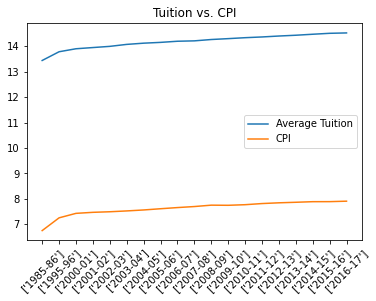

In [79]:
#Chart cost of tuition for all institutions in constant $ vs cpi 
temp_1 = tuition_vs_inflation[(tuition_vs_inflation['type']=='All Institutions')&(tuition_vs_inflation['tuition_type']=='All Constant')][['avg_tuition', 'year']].copy()
temp_2 = tuition_vs_inflation[(tuition_vs_inflation['type']=='All Institutions')&(tuition_vs_inflation['tuition_type']=='All Constant')][['cpi', 'year']].copy()

temp_1['avg_tuition'] = np.log2(temp_1['avg_tuition'])
temp_2['cpi'] = np.log2(temp_2['cpi'])

axis_labels = temp_1[['year']].values
x_axis = np.arange(0, len(axis_labels), 1)
plt.xticks(x_axis, axis_labels, rotation=45)
plt.plot(x_axis,temp_1['avg_tuition'])
plt.plot(x_axis,temp_2['cpi'])
plt.legend(['Average Tuition', 'CPI'])
plt.title('Tuition vs. CPI')
plt.savefig('./images/tuition_cpi_value')

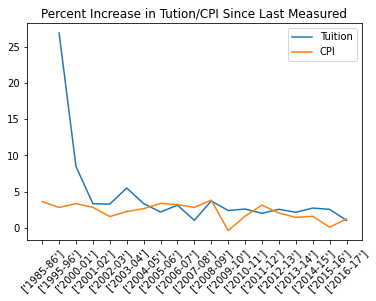

In [96]:
#Chart difference in tuition changes between years
temp_1 = tuition_vs_inflation[(tuition_vs_inflation['type']=='All Institutions')&(tuition_vs_inflation['tuition_type']=='All Constant')][['year','1_year_change_tuition']].copy()
temp_2 = tuition_vs_inflation[(tuition_vs_inflation['type']=='All Institutions')&(tuition_vs_inflation['tuition_type']=='All Constant')][['year','1_year_change_cpi']].copy()



axis_labels = temp_1[['year']].values
x_axis = np.arange(0, len(axis_labels), 1)
plt.xticks(x_axis, axis_labels, rotation=45)
plt.title('Percent Increase in Tution/CPI Since Last Measured')
plt.plot(x_axis,temp_1['1_year_change_tuition'])
plt.plot(x_axis,temp_2['1_year_change_cpi'])
plt.legend(['Tuition', 'CPI'])
plt.savefig('./images/tuition_cpi_change_percent')

In [85]:
temp_1

,year,1_year_change_tuition
0,1985-86,NaN
18,1995-96,26.888869
36,2000-01,8.489097
54,2001-02,3.347908
72,2002-03,3.296287
90,2003-04,5.514122
108,2004-05,3.371958
126,2005-06,2.202668
144,2006-07,3.142309
150,2007-08,1.063377


In [86]:
temp_1.drop([0,18, 36]).describe()

,1_year_change_tuition
count,16.000000
mean,2.740106
std,1.060769
min,1.049206
25%,2.193825
50%,2.598774
75%,3.309192
max,5.514122


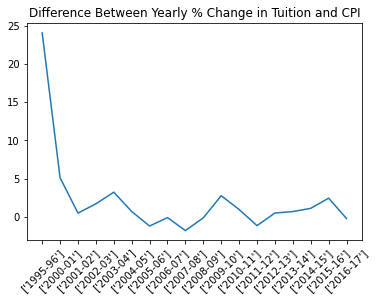

In [87]:
#Does current tuition = past tuition * inflation rate
temp_1 = tuition_vs_inflation[(tuition_vs_inflation['type']=='All Institutions')&(tuition_vs_inflation['tuition_type']=='All Constant')][['year','dif_1_year']].copy()

axis_labels = temp_1[['year']].values
x_axis = np.arange(0, len(axis_labels), 1)
plt.xticks(x_axis, axis_labels, rotation=45)
plt.title('Difference Between Yearly % Change in Tuition and CPI')
plt.plot(x_axis,temp_1['dif_1_year'])
plt.savefig('./images/difference_tuition_cpi_percent_change')

In [88]:
temp_1.drop([0,18, 36])['dif_1_year'].describe()

count    16.000000
mean      0.637114
std       1.421672
min      -1.784837
25%      -0.139179
50%       0.607934
75%       1.273692
max       3.235078
Name: dif_1_year, dtype: float64

In [92]:
tuition_vs_inflation.columns
cpi_change = tuition_vs_inflation[(tuition_vs_inflation['type'] == 'All Institutions') & (tuition_vs_inflation['tuition_type']== 'All Constant')][['year','1_year_change_cpi']]

In [93]:
cpi_change.describe()

,1_year_change_cpi
count,19.000000
mean,2.289099
std,1.158498
min,-0.355778
25%,1.601608
50%,2.663043
75%,3.191168
max,3.839550
